In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score

In [5]:
# Charger le dataset
data = pd.read_csv('tweets_suspect.csv')  # 'fichier des tweets suspects
print(data.head())
#print(data['message'].value_counts())  # Vérification de la répartition des classes des tweets


                                             message  label
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...      1
1  is upset that he can't update his Facebook by ...      1
2  @Kenichan I dived many times for the ball. Man...      1
3    my whole body feels itchy and like its on fire       0
4  @nationwideclass no, it's not behaving at all....      1


In [16]:
data.iloc[0,0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

## Analyse unvariée

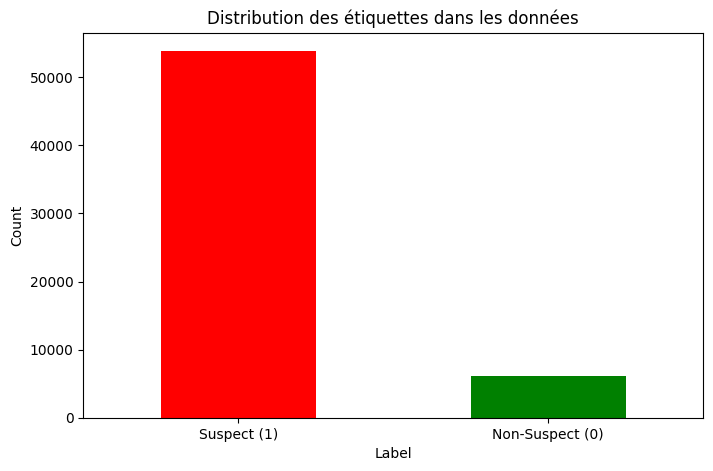

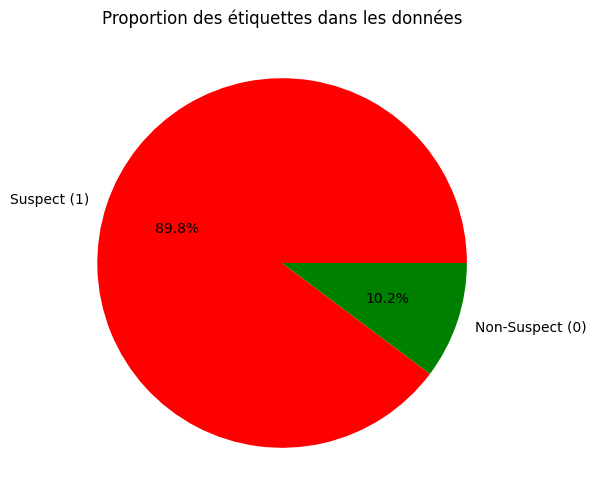

In [6]:
# Calculer la distribution des labels
label_distribution = data['label'].value_counts()

# Définir les couleurs pour chaque catégorie
colors = ['green' if label == 0 else 'red' for label in label_distribution.index]

# Afficher la distribution sous forme de graphique
plt.figure(figsize=(8, 5))
label_distribution.plot(kind='bar', color=colors)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution des étiquettes dans les données')
plt.xticks(ticks=[0, 1], labels=['Suspect (1)','Non-Suspect (0)'], rotation=0)
plt.show()
plt.figure(figsize=(6, 6))
label_distribution.plot(kind='pie', autopct='%1.1f%%', colors=['red', 'green'], labels=['Suspect (1)','Non-Suspect (0)'])
plt.ylabel('')
plt.title('Proportion des étiquettes dans les données')
plt.show()



In [7]:
# Gestion du déséquilibre des classes par sous-échantillonnage
data_majoritaire = data[data['label'] == 1]  # Classe non suspecte (majoritaire)
data_minoritaire = data[data['label'] == 0]  # Classe suspecte (minoritaire)

# Sous-échantillonnage de la classe majoritaire
data_majoritaire_sous = resample(data_majoritaire,
                                 replace=False,    # échantillonnage sans remplacement
                                 n_samples=len(data_minoritaire),  # égaliser au nombre de la classe minoritaire
                                 random_state=42)

# Combiner les deux classes après équilibrage
data_equilibree = pd.concat([data_majoritaire_sous, data_minoritaire])

# Vérification de la nouvelle répartition des classes
print(data_equilibree['label'].value_counts())

label
1    6145
0    6145
Name: count, dtype: int64


##  Nettoyage du texte avec SpaCy

In [8]:
# Charger le modèle SpaCy anglais
nlp = spacy.load("en_core_web_sm")

# Nettoyage du texte avec SpaCy
def nettoyer_texte_spacy(texte):
    doc = nlp(texte.lower())  # Convertir en minuscules et traiter avec SpaCy
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return ' '.join(tokens)

# Appliquer le nettoyage sur chaque texte
data_equilibree['message_nettoye'] = data_equilibree['message'].apply(nettoyer_texte_spacy)

## Vectorisation

In [9]:
# Vectorisation avec TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(data_equilibree['message_nettoye']).toarray()
y=data_equilibree['label'].values
# Encodage de la variable cible
#le = LabelEncoder()
#y = le.fit_transform(data['message'])


## Entrainement du modèle

In [10]:

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [11]:
# Définition des modèles
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC()
}



## Evaluation sans ajustement des hyperparametres


Scores de validation croisée : [0.89377632 0.89720512 0.89513109 0.88399817 0.88579387]
Score moyen de validation croisée : 0.891180912398584

Logistic Regression
              precision    recall  f1-score   support

           0       0.97      0.79      0.87      1229
           1       0.82      0.98      0.90      1229

    accuracy                           0.89      2458
   macro avg       0.90      0.89      0.88      2458
weighted avg       0.90      0.89      0.88      2458



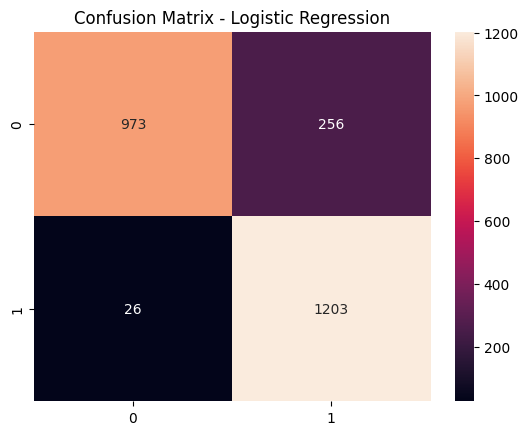

Scores de validation croisée : [0.92833093 0.93108434 0.92960463 0.92564347 0.92689919]
Score moyen de validation croisée : 0.9283125104314441

Random Forest
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      1229
           1       0.89      0.98      0.94      1229

    accuracy                           0.93      2458
   macro avg       0.94      0.93      0.93      2458
weighted avg       0.94      0.93      0.93      2458



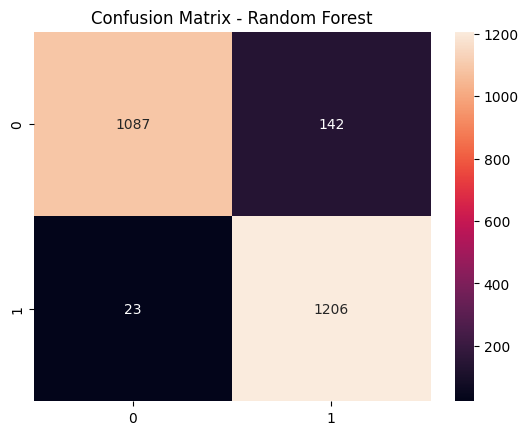

Scores de validation croisée : [0.90018657 0.90201594 0.9038282  0.88705234 0.89578509]
Score moyen de validation croisée : 0.8977736264772525

SVM
              precision    recall  f1-score   support

           0       0.99      0.80      0.88      1229
           1       0.83      0.99      0.90      1229

    accuracy                           0.90      2458
   macro avg       0.91      0.90      0.89      2458
weighted avg       0.91      0.90      0.89      2458



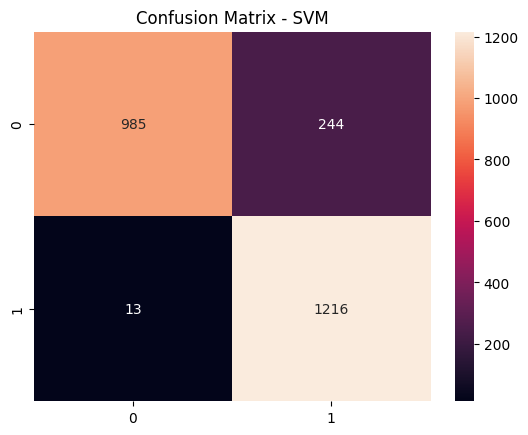

In [12]:
# Entraînement et évaluation des modèles
for name, model in models.items():
    model.fit(X_train, y_train)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    print("Scores de validation croisée :", scores)
    print("Score moyen de validation croisée :", scores.mean())
    y_pred = model.predict(X_test)
    print(f"\n{name}")
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

## Ajustement des hyperparametres par la methode de GridSearchCV


In [13]:
from sklearn.model_selection import GridSearchCV

# Ajustement des hyperparamètres avec GridSearchCV
param_grid = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [10, 20, None]},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
}

best_models = {}
for name, model in models.items():
    grid = GridSearchCV(model, param_grid[name], cv=5, scoring='f1_macro')
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(f"\nBest parameters for {name}: {grid.best_params_}")

C:\Users\hamad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hamad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


Best parameters for Logistic Regression: {'C': 10}

Best parameters for Random Forest: {'max_depth': None, 'n_estimators': 200}

Best parameters for SVM: {'C': 1, 'kernel': 'linear'}


## Evaluation sans ajustement des hyperparametres

C:\Users\hamad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hamad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Scores de validation croisée : [0.91420262 0.91540342 0.92068127 0.9082218  0.90987536]
Score moyen de validation croisée : 0.9136768925199767

Logistic Regression
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      1229
           1       0.87      0.96      0.91      1229

    accuracy                           0.91      2458
   macro avg       0.91      0.91      0.91      2458
weighted avg       0.91      0.91      0.91      2458



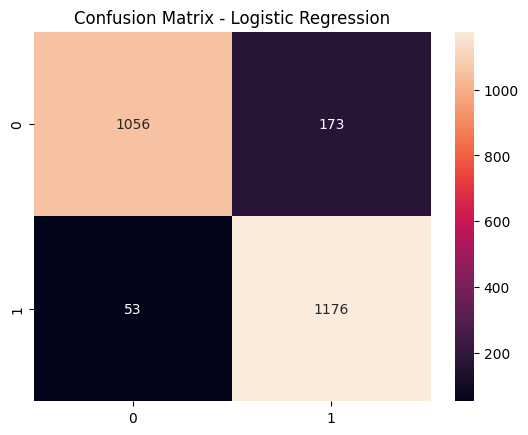

Scores de validation croisée : [0.92870906 0.93158661 0.93140097 0.92469018 0.92696897]
Score moyen de validation croisée : 0.9286711570749324

Random Forest
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      1229
           1       0.89      0.98      0.94      1229

    accuracy                           0.93      2458
   macro avg       0.94      0.93      0.93      2458
weighted avg       0.94      0.93      0.93      2458



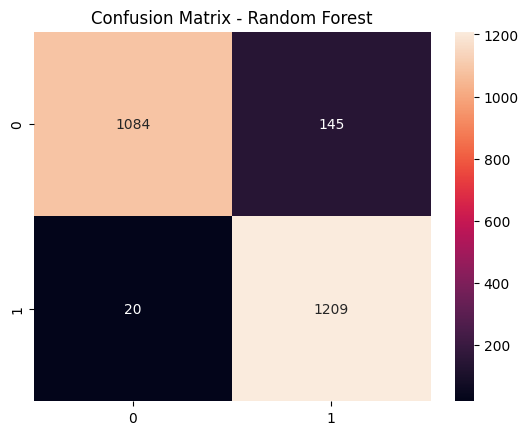

Scores de validation croisée : [0.92190476 0.92470024 0.92689919 0.91619586 0.91863765]
Score moyen de validation croisée : 0.9216675400184966

SVM
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      1229
           1       0.87      0.99      0.93      1229

    accuracy                           0.92      2458
   macro avg       0.93      0.92      0.92      2458
weighted avg       0.93      0.92      0.92      2458



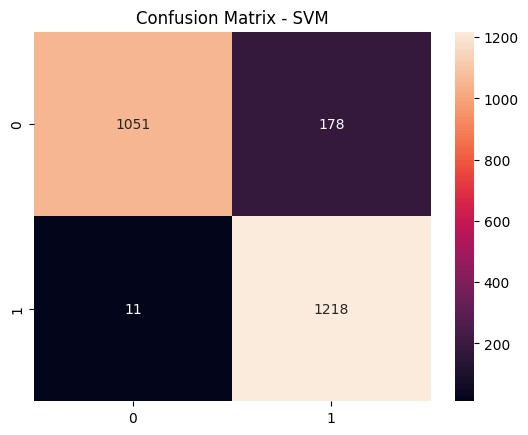

In [15]:


# Définition des modèles avec gestion des meilleurs paramètres spécifiés
models = {
    'Logistic Regression': LogisticRegression(C=10),
    'Random Forest': RandomForestClassifier(max_depth=None, n_estimators=100),
    'SVM': SVC(C=1,kernel='linear')
}

# Entraînement, évaluation et sauvegarde des modèles
for name, model in models.items():
    model.fit(X_train, y_train)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    print("Scores de validation croisée :", scores)
    print("Score moyen de validation croisée :", scores.mean())
    y_pred = model.predict(X_test)
    print(f"\n{name}")
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()